In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_array = cv2.imread("Dataset/FaceMask/00000_Mask.jpg")

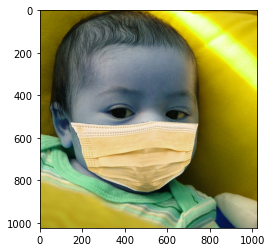

In [3]:
plt.imshow(img_array) #BGR

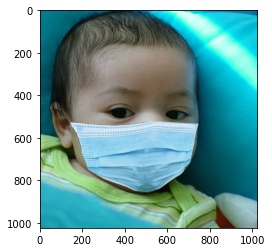

In [4]:
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))

In [5]:
img_array.shape

(1024, 1024, 3)

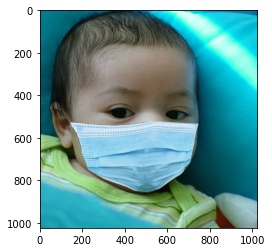

In [6]:
Datadirectory = "Dataset/" #training dataset
Classes = ["FaceMask", "NoMask"] #class list
for category in Classes:
    path = os.path.join(Datadirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

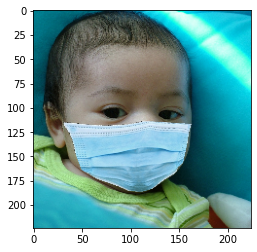

In [7]:
img_size = 224 # ImageNet => 224x224

new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

 ## Reading the images & converting them to array

In [8]:
training_Data = [] # data

def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category) # => 0,1 -> Labels
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_Data.append([new_array, class_num])
            except Exception as e:
                pass

In [9]:
create_training_Data()

In [10]:
print(len(training_Data))

1950


In [11]:
import random

random.shuffle(training_Data)

In [12]:
X = [] #Data / Features
Y = [] #Label

for features, label in training_Data:
    X.append(features)
    Y.append(label)
    
X = np.array(X).reshape(-1, img_size, img_size, 3)

In [13]:
X.shape

(1950, 224, 224, 3)

In [14]:
# normalizing the data

X = X/255.0;

In [15]:
Y[500]

1

In [16]:
y = np.array(Y)

In [17]:
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("Y.pickle", "wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

In [18]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("Y.pickle","rb")
Y = pickle.load(pickle_in)

## Deep learning model for training / Transfer Learning

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [20]:
model = tf.keras.applications.mobilenet.MobileNet() #pre-trained model

In [21]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

# Transfer Learning
### Tuning, weights will start from last check point

In [22]:
base_input = model.layers[0].input

In [23]:
base_output = model.layers[-4].output

In [24]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer) #0 1
final_output = layers.Activation('sigmoid')(final_output)

In [25]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [26]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

## Setting for Binary Classification (W/out Mask)

In [27]:
new_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [28]:
new_model.fit(X,y, epochs = 1, validation_split = 0.1)

55/55 [==============================] - 233s 4s/step - loss: 0.0170 - accuracy: 0.9897 - val_loss: 0.1475 - val_accuracy: 0.9795


In [29]:
new_model.save('my_model3.h5')

In [30]:
new_model = tf.keras.models.load_model('my_model3.h5')

## Cheking the network for prediction

In [31]:
frame = cv2.imread('00002_Mask.jpg')

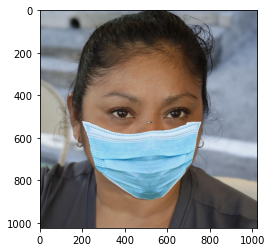

In [32]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [33]:
final_image = cv2.resize(frame, (224, 224))
final_image = np.expand_dims(final_image, axis = 0) ##4th Dimension
final_image = final_image/255.0

In [34]:
Predictions = new_model.predict(final_image)

1/1 [==============================] - 1s 519ms/step


In [35]:
Predictions

array([[6.851892e-14]], dtype=float32)

In [36]:
frame = cv2.imread('smiling_woman.jpg')

In [37]:
frame.shape

(2106, 3743, 3)

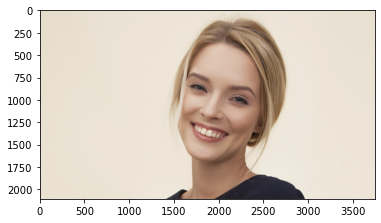

In [62]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [38]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [39]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [40]:
gray.shape

(2106, 3743)

In [41]:
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+h]
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("NO FACE DETECTED!")
    else:
        for(ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey:ey+eh, ex:ex+ew]

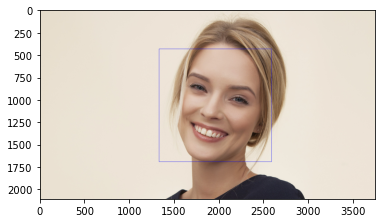

In [42]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

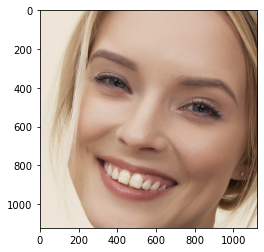

In [43]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [44]:
final_image = cv2.resize(face_roi, (224,224))
final_image = np.expand_dims(final_image, axis = 0) #4th dimension
final_image = final_image/255.0

In [45]:
Predictions = new_model.predict(final_image)

1/1 [==============================] - 0s 76ms/step


In [46]:
Predictions

array([[0.9999314]], dtype=float32)

# FaceMask Detection
## Realtime video demo

In [ ]:
import cv2

path = 'haarcascade_frontalface_default.xml'
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

rectangle_bgr = (255, 255, 255) # Rectangle bckground white
img = np.zeros((500, 500)) # Making a black image
text = "Some text in a box!" # Set some text
# width & height of the text box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale = font_scale, thickness = 1)[0] 

text_offset_x = 10
text_offset_y = img.shape[0] - 25 # Text starting position at x,y

# Making the coordinates of the box with a small padding of 2 pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale = font_scale, color = (0, 0, 0), thickness = 1)

cap = cv2.VideoCapture(1) # Webcam checking (On/Off)

if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("NO CAMERA FOUND!")
    
while True:
    ret, frame = cap.read()
    
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+h]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
            print("NO FACE DETECTED!")
        else:
            for(ex, ey, ew, eh) in facess:
                face_roi = roi_color[ey:ey+eh, ex:ex+ew] # Cropping the deteted face
                
    final_image = cv2.resize(face_roi, (224,224))
    final_image = np.expand_dims(final_image, axis = 0) # 4th dimension
    final_image = final_image/255.0
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    Predictions = new_model.predict(final_image)
    
    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN
    
    if (Predictions>0.1):
        status = "No Mask"
        
        x1, y1, w1, h1 = 0, 0, 175, 75
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (255,255,255), -1) #Rectangle background black
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2) #Adding text
        
        cv2.putText(frame, status, (100, 150), font, 3, (0,0,255), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0,0,255))
    else:
        status = "Face Mask"
        
        x1, y1, w1, h1 = 0, 0, 175, 75
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (0,0,0), -1) #Rectangle background black
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2) #Adding text
        
        cv2.putText(frame, status, (100, 150), font, 3, (0,255,0), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0,255,0))
        
    cv2.imshow('Face Mask Detection', frame)
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()